In [1]:
# packages required for new environment
# ! pip install pandas
# ! pip install nltk
# ! pip install datasets
# ! pip install tqdm
# ! pip install ipywidgets
# ! pip install Pillow

In [1]:
#Libraries
import pandas as pd
import numpy as np
import datasets
import nltk
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf


# import tensorflow_datasets as tfds
import tensorflow as tf  # For tf.data
import keras
from keras import layers
from tensorflow.keras import regularizers
from keras.applications import EfficientNetB0

# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 64
BATCH_SIZE = 64
NUM_CLASSES = 10
EPOCHS = 30
LR = 1e-3

# Dataset 1

In [3]:
# 1. tiny-imagenet
#   (a) Dataset Summary - Tiny ImageNet contains 100,000+ images of 200 classes (500 for each class) downsized to 64×64 colored images. Each class has 500 training images, 50 validation images, and 50 test images.
#   (b) Data Feature Dimensions -
#       i. Image: A PIL.Image.Image object containing the image.
#       ii. Label: an int classification label. -1 for the test set as the labels are missing. Check classes.py for the map of numbers and labels.

In [4]:
# # Retrieve data directly from Stanford data source
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip -qq 'tiny-imagenet-200.zip'
# DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]
# # Define training and validation data paths
# TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
# VALID_DIR = os.path.join(DATA_DIR, 'val')

In [2]:
DATA_DIR = 'tiny-imagenet-200' # Original images come in shapes of [3,64,64]

# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')
random.seed(42)

# get all class id and label from words.txt
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for id, line in enumerate(data):
    words = line.strip('\n').split('\t')
    class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

In [3]:
# Training datset creation 
tiny_imagenet_train = pd.DataFrame()
for root, directories, files in os.walk(TRAIN_DIR):
    for directory in directories:
        d = pd.read_csv(os.path.join(root,directory, directory + "_boxes.txt"), 
                       sep='\t', 
                       header=None, 
                       names=['File', 'X', 'Y', 'H', 'W'])
        tiny_imagenet_train = pd.concat([tiny_imagenet_train,d])
    break
tiny_imagenet_train["Class"]=tiny_imagenet_train.apply(lambda row: row.File.split('_')[0], axis=1)
tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: os.path.join(root, row.Class ,"images", row.File), axis=1)
# tiny_imagenet_train.File=tiny_imagenet_train.apply(lambda row: load_image(os.path.join(root, row.Class ,"images", row.File)), axis=1)
tiny_imagenet_train['label_name']=tiny_imagenet_train.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
tiny_imagenet_train = tiny_imagenet_train.sample(frac=1).reset_index(drop=True)
tiny_imagenet_train

,File,X,Y,H,W,Class,label_name
0,tiny-imagenet-200/train/n02099712/images/n0209...,18,5,63,63,n02099712,Labrador retriever
1,tiny-imagenet-200/train/n04275548/images/n0427...,0,3,63,61,n04275548,spider web
2,tiny-imagenet-200/train/n02226429/images/n0222...,0,10,63,59,n02226429,grasshopper
3,tiny-imagenet-200/train/n01629819/images/n0162...,22,27,50,40,n01629819,European fire salamander
4,tiny-imagenet-200/train/n03179701/images/n0317...,0,22,63,63,n03179701,desk
...,...,...,...,...,...,...,...
99995,tiny-imagenet-200/train/n02883205/images/n0288...,16,43,30,51,n02883205,bow tie
99996,tiny-imagenet-200/train/n02058221/images/n0205...,0,18,63,63,n02058221,albatross
99997,tiny-imagenet-200/train/n04540053/images/n0454...,21,10,28,17,n04540053,volleyball
99998,tiny-imagenet-200/train/n03992509/images/n0399...,6,9,63,63,n03992509,potter's wheel


In [4]:
class_to_label_number_dict = dict()
unique_train_class = tiny_imagenet_train.Class.value_counts().keys()
for idx, Class in enumerate(unique_train_class):
    class_to_label_number_dict[Class] = idx
label_number_to_class = {y : x for x, y in class_to_label_number_dict.items()}

In [5]:
# Validation dataset creation 

# Display first 20 entries of resulting dictionary
tiny_imagenet_valid = pd.read_csv(f'{VALID_DIR}/val_annotations.txt', 
                       sep='\t', 
                       header=None, 
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

# attaching label to respective class 
tiny_imagenet_valid["label_name"] = tiny_imagenet_valid.apply(lambda row: class_to_name_dict[row.Class], axis= 1)
# tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: load_image(os.path.join(VALID_DIR,"images", row.File)), axis=1)
tiny_imagenet_valid.File=tiny_imagenet_valid.apply(lambda row: os.path.join(VALID_DIR,"images", row.File), axis=1)
tiny_imagenet_valid = tiny_imagenet_valid.sample(frac=1).reset_index(drop=True)
tiny_imagenet_valid

,File,Class,X,Y,H,W,label_name
0,tiny-imagenet-200/val/images/val_8760.JPEG,n01944390,0,22,36,41,snail
1,tiny-imagenet-200/val/images/val_3580.JPEG,n07871810,0,13,63,50,meat loaf
2,tiny-imagenet-200/val/images/val_2625.JPEG,n02165456,22,9,48,48,ladybug
3,tiny-imagenet-200/val/images/val_3151.JPEG,n03126707,3,0,45,63,crane
4,tiny-imagenet-200/val/images/val_4102.JPEG,n03404251,1,0,63,63,fur coat
...,...,...,...,...,...,...,...
9995,tiny-imagenet-200/val/images/val_9808.JPEG,n02795169,38,0,63,33,barrel
9996,tiny-imagenet-200/val/images/val_4012.JPEG,n02795169,15,11,53,63,barrel
9997,tiny-imagenet-200/val/images/val_1556.JPEG,n04285008,0,24,63,44,sports car
9998,tiny-imagenet-200/val/images/val_3032.JPEG,n01698640,0,23,50,51,American alligator


In [6]:

limited_classes = list(class_to_label_number_dict.keys())[:NUM_CLASSES]
train_drop_index = tiny_imagenet_train[~tiny_imagenet_train.Class.isin(limited_classes)].index
valid_drop_index = tiny_imagenet_valid[~tiny_imagenet_valid.Class.isin(limited_classes)].index

tiny_imagenet_valid.drop( valid_drop_index, inplace=True)
tiny_imagenet_train.drop( train_drop_index, inplace=True)

tiny_imagenet_train['label_number']=tiny_imagenet_train.apply(lambda row: class_to_label_number_dict[row.Class], axis= 1)
tiny_imagenet_valid['label_number']=tiny_imagenet_valid.apply(lambda row: class_to_label_number_dict[row.Class], axis= 1)

tiny_imagenet_train

,File,X,Y,H,W,Class,label_name,label_number
0,tiny-imagenet-200/train/n02099712/images/n0209...,18,5,63,63,n02099712,Labrador retriever,0
179,tiny-imagenet-200/train/n04067472/images/n0406...,0,12,59,63,n04067472,reel,2
183,tiny-imagenet-200/train/n04285008/images/n0428...,10,22,37,42,n04285008,sports car,3
184,tiny-imagenet-200/train/n09332890/images/n0933...,13,37,63,63,n09332890,lakeside,4
185,tiny-imagenet-200/train/n03100240/images/n0310...,0,10,63,46,n03100240,convertible,5
...,...,...,...,...,...,...,...,...
99791,tiny-imagenet-200/train/n04562935/images/n0456...,28,9,62,63,n04562935,water tower,7
99869,tiny-imagenet-200/train/n03100240/images/n0310...,5,24,61,47,n03100240,convertible,5
99870,tiny-imagenet-200/train/n02099712/images/n0209...,26,22,63,57,n02099712,Labrador retriever,0
99891,tiny-imagenet-200/train/n04562935/images/n0456...,19,0,38,42,n04562935,water tower,7


In [7]:
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.cast(image, tf.uint8)  # Ensure image data type is uint8
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# creating train dataset loader
image = tf.convert_to_tensor(tiny_imagenet_train.File.values)
labels = tiny_imagenet_train.label_number.values
ds_train = tf.data.Dataset.from_tensor_slices((image, labels))

ds_train = ds_train.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

# creating valid dataset loader
image = tf.convert_to_tensor(tiny_imagenet_valid.File.values)
labels = tiny_imagenet_valid.label_number.values
ds_valid = tf.data.Dataset.from_tensor_slices((image, labels))

ds_valid = ds_valid.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
ds_valid = ds_valid.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

In [8]:
# input size
print(ds_train.element_spec)

(TensorSpec(shape=(64, 64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(64, 10), dtype=tf.float32, name=None))


Image shape: (64, 64, 64, 3)


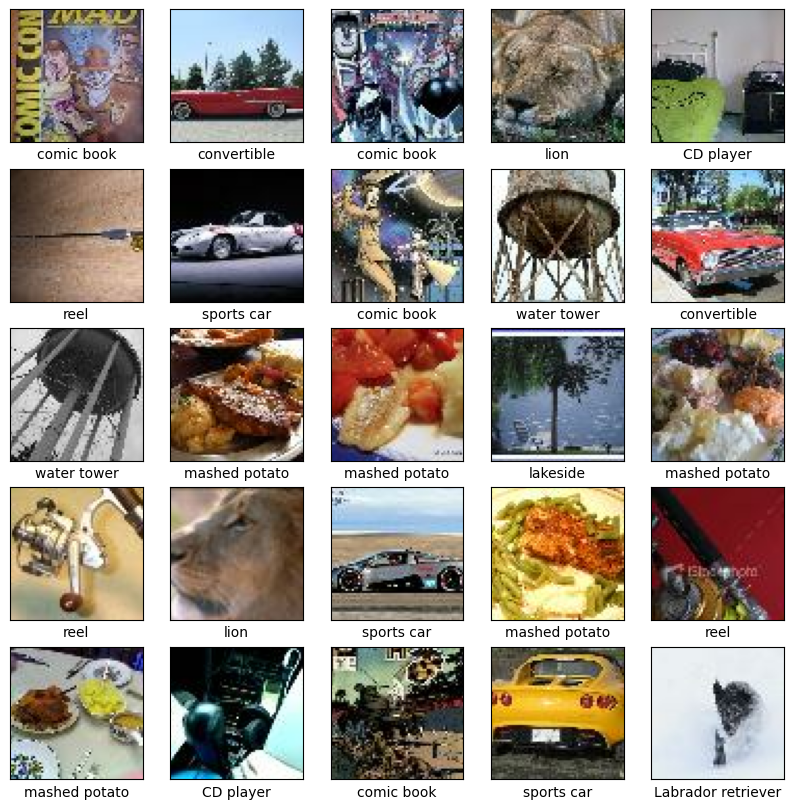

In [9]:
# Take one element from the dataset
sample = ds_valid.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break



Image shape: (64, 64, 64, 3)


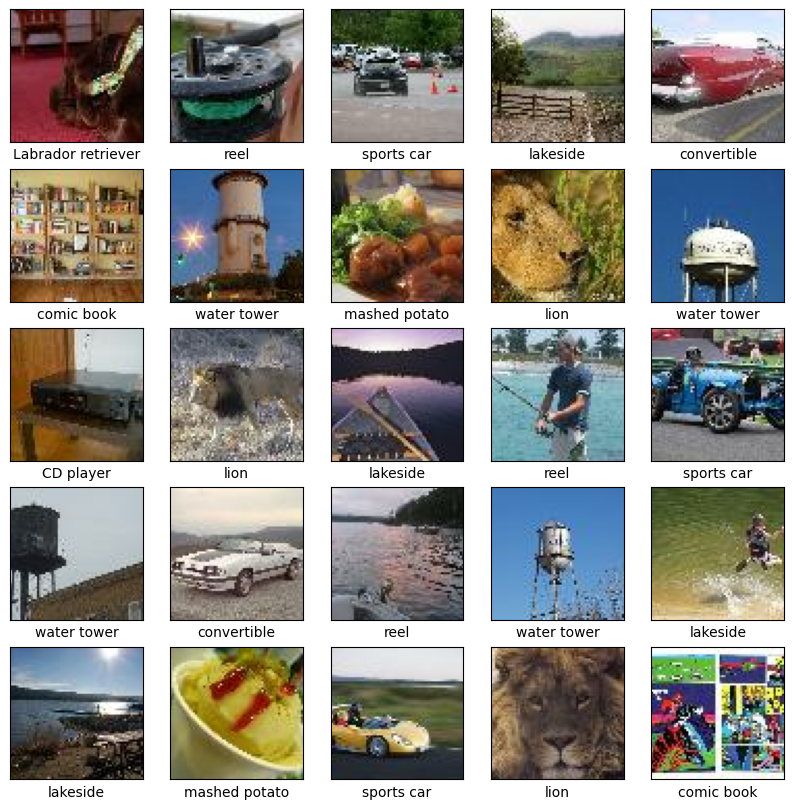

In [10]:
# Take one element from the dataset
sample = ds_train.take(1)

plt.figure(figsize=(10,10))
# Iterate through the dataset and print images and label
for image, label in sample:
    # Convert image tensor to NumPy array for visualization
    image_np = image.numpy()
    print("Image shape:", image_np.shape)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(image_np[i])
        plt.xlabel(class_to_name_dict[label_number_to_class[np.argmax(label[i])]])
    plt.show()
    break



In [11]:
# for 50 classes
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [28]:
def plot_hist_all(hist, hist1, hist2, hist3):
    plt.figure(figsize=(10, 6))  # Adjust figure size here

    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.plot(hist1.history["accuracy"])
    plt.plot(hist1.history["val_accuracy"])
    plt.plot(hist2.history["accuracy"])
    plt.plot(hist2.history["val_accuracy"])
    plt.plot(hist3.history["accuracy"])
    plt.plot(hist3.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    
    # Move legend outside the plot and adjust its position
    plt.legend(["Train-WOR", "Validation-WOR", "Train-L2", "Validation-L2", 
                "Train-Dropout", "Validation-Dropout", "Train-Ensemble", "Validation-Ensemble"], 
               loc="center left", bbox_to_anchor=(1, 0.5))
    
    plt.show()

In [13]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same', input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same'),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    # tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.09,
#     decay_steps=100,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
model.compile(
    optimizer="adam", 
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model.summary())
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_accuracy",
#         # "no longer improving" being defined as "for at least 3 epochs"
#         patience=10,
#         verbose=1,
#     )
# ]

# Train the model
model_output = model.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    # callbacks=callbacks,
    )

# Evaluate the model
loss, accuracy = model.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/Users/hrishikesh/miniconda3/envs/MLCS_project/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,316,554 (20.28 MB)

 Trainable params: 5,316,554 (20.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 189ms/step - accuracy: 0.1047 - loss: 3.6523 - val_accuracy: 0.1562 - val_loss: 2.2871
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.1137 - loss: 2.3082 - val_accuracy: 0.1228 - val_loss: 2.2968
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.1241 - loss: 2.2609 - val_accuracy: 0.1942 - val_loss: 2.0701
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 0.1863 - loss: 2.1007 - val_accuracy: 0.2210 - val_loss: 2.0186
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.2332 - loss: 2.0142 - val_accuracy: 0.2277 - val_loss: 1.9893
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.2693 - loss: 1.9000 - val_accuracy: 0.2902 - val_loss: 1.8526
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 192ms/step - accuracy: 0.3179 - loss: 1.7779 - val_accuracy: 0.3281 - val_loss: 1.7290
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 187ms/step - accuracy: 0.3396 - loss: 1.7285 - val

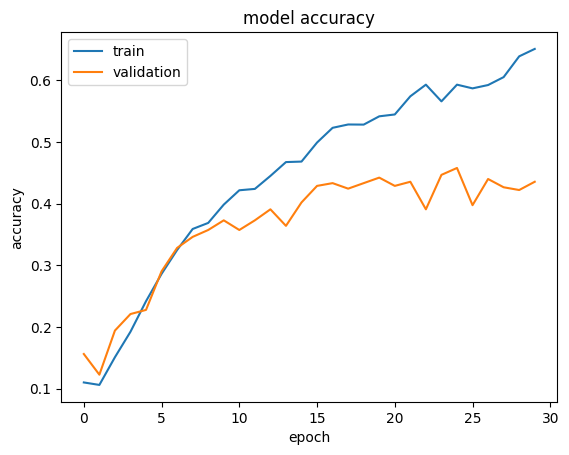

In [14]:

plot_hist(model_output)

In [15]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_l2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same',
                            input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same',
                           ),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    # tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.09,
#     decay_steps=100,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
model_l2.compile(
    optimizer="adam", 
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_l2.summary())

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_accuracy",
#         # "no longer improving" being defined as "for at least 3 epochs"
#         patience=15,
#         verbose=1,
#     )
# ]

# Train the model
model_output_l2 = model_l2.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    # callbacks=callbacks,
    )

# Evaluate the model
loss, accuracy = model_l2.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,316,554 (20.28 MB)

 Trainable params: 5,316,554 (20.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 187ms/step - accuracy: 0.1019 - loss: 4.6051 - val_accuracy: 0.1004 - val_loss: 2.3283
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.1331 - loss: 2.2817 - val_accuracy: 0.1786 - val_loss: 2.1385
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.1915 - loss: 2.1316 - val_accuracy: 0.2299 - val_loss: 2.0664
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 189ms/step - accuracy: 0.2259 - loss: 2.0415 - val_accuracy: 0.2589 - val_loss: 1.9550
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.2724 - loss: 1.9180 - val_accuracy: 0.2768 - val_loss: 1.9475
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 201ms/step - accuracy: 0.3237 - loss: 1.8434 - val_accuracy: 0.3616 - val_loss: 1.7884
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 198ms/step - accuracy: 0.3482 - loss: 1.7534 - val_accuracy: 0.3661 - val_loss: 1.7469
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.3793 - loss: 1.6955 - val

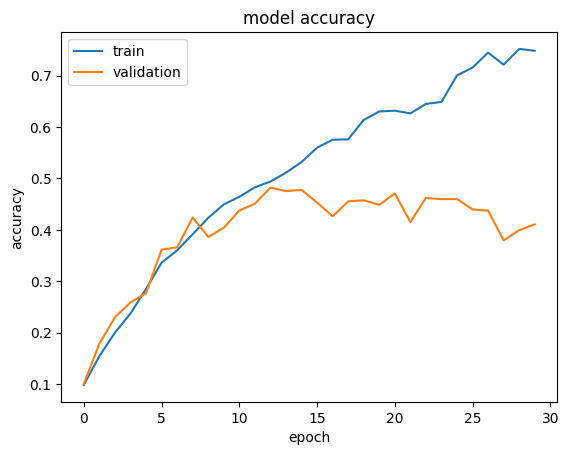

In [16]:
plot_hist(model_output_l2)

In [18]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_dropout = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same',
                            input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same',
                           ),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.09,
#     decay_steps=100,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
model_dropout.compile(
    optimizer="adam", 
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_dropout.summary())

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_accuracy",
#         # "no longer improving" being defined as "for at least 3 epochs"
#         patience=15,
#         verbose=1,
#     )
# ]

# Train the model
model_output_dropout = model_dropout.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    # callbacks=callbacks,
    )

# Evaluate the model
loss, accuracy = model_dropout.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,316,554 (20.28 MB)

 Trainable params: 5,316,554 (20.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 167ms/step - accuracy: 0.1101 - loss: 3.3835 - val_accuracy: 0.1964 - val_loss: 2.0879
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 166ms/step - accuracy: 0.1945 - loss: 2.1097 - val_accuracy: 0.2009 - val_loss: 2.1183
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.2205 - loss: 2.0650 - val_accuracy: 0.2009 - val_loss: 2.1589
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.2478 - loss: 1.9996 - val_accuracy: 0.2679 - val_loss: 1.9083
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.2811 - loss: 1.8808 - val_accuracy: 0.2902 - val_loss: 1.8657
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 206ms/step - accuracy: 0.2935 - loss: 1.8685 - val_accuracy: 0.3504 - val_loss: 1.7965
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.3475 - loss: 1.7324 - val_accuracy: 0.3304 - val_loss: 1.8157
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.3641 - loss: 1.6993 - val

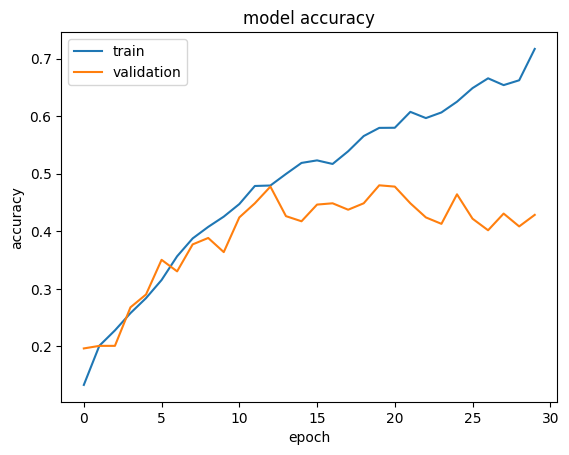

In [19]:
plot_hist(model_output_dropout)

In [21]:
# Define the input shape
input_shape = [None, IMG_SIZE, IMG_SIZE, 3]

# Define the model architecture
model_ensemble = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, kernel_size=(11, 11), strides=4, activation='relu', padding='same',
                            input_shape=input_shape[1:]),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(192, kernel_size=(5, 5), activation='relu', padding='same',
                           ),
    tf.keras.layers.Lambda(lambda x: tf.nn.local_response_normalization(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75)),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same',
                           ),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding='same'),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00002)),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.09,
#     decay_steps=100,
#     decay_rate=0.9)
# optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# Compile the model
model_ensemble.compile(
    optimizer="adam", 
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    loss="categorical_crossentropy",
    metrics=['accuracy'])

# Print the model summary
print(model_ensemble.summary())

# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         # Stop training when `val_loss` is no longer improving
#         monitor="val_accuracy",
#         # "no longer improving" being defined as "for at least 3 epochs"
#         patience=15,
#         verbose=1,
#     )
# ]

# Train the model
model_output_ensemble = model_ensemble.fit(
    ds_train, 
    epochs=EPOCHS, 
    validation_data=ds_valid, 
    batch_size=BATCH_SIZE,
    # callbacks=callbacks,
    )

# Evaluate the model
loss, accuracy = model_ensemble.evaluate(ds_valid)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_10 (Lambda)              │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 192)      │       307,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_11 (Lambda)              │ (None, 8, 8, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 4, 4, 384)      │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 4, 4, 384)      │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 4, 4, 256)      │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,316,554 (20.28 MB)

 Trainable params: 5,316,554 (20.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 165ms/step - accuracy: 0.1003 - loss: 3.5096 - val_accuracy: 0.1250 - val_loss: 2.3124
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 0.1131 - loss: 2.3149 - val_accuracy: 0.1696 - val_loss: 2.1556
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 16s 205ms/step - accuracy: 0.1808 - loss: 2.1667 - val_accuracy: 0.1808 - val_loss: 2.3654
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 193ms/step - accuracy: 0.1915 - loss: 2.1449 - val_accuracy: 0.2634 - val_loss: 1.9618
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.2633 - loss: 1.9298 - val_accuracy: 0.2969 - val_loss: 1.8797
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.3043 - loss: 1.8399 - val_accuracy: 0.2835 - val_loss: 1.9408
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.3413 - loss: 1.7748 - val_accuracy: 0.3571 - val_loss: 1.7899
Epoch 8/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 15s 197ms/step - accuracy: 0.3755 - loss: 1.6831 - val

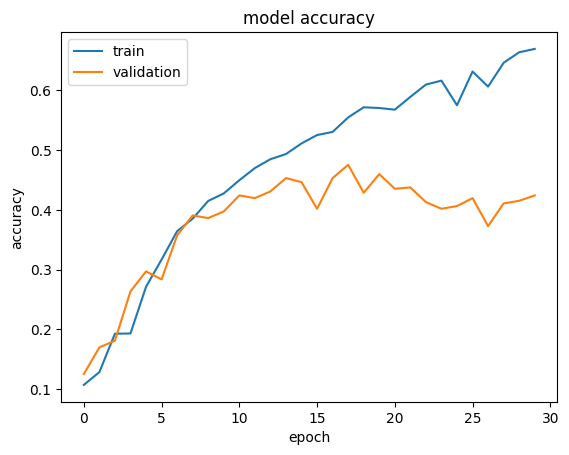

In [22]:
plot_hist(model_output_ensemble)

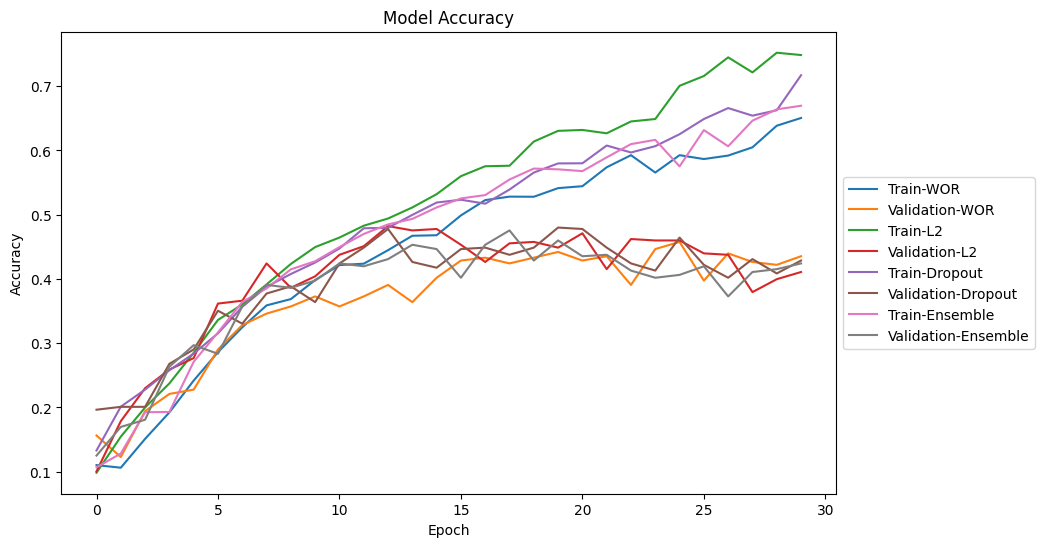

In [29]:
plot_hist_all(model_output, model_output_l2, model_output_dropout, model_output_ensemble)

# Regularization Techniques for Dataset 1

In [23]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#              - RandomErasing is concerned about removing and randomly adding information on the
#               blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#               Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 1 - applying RandomErasing and MaxDropout together. Applied to Dataset1.

# Dataset 2

In [24]:
# 2. nltk-brown + nltk-treebank + nltk-conll2000
#   (a) Dataset Summary - The combination of these 3 datasets gives us a large corpus of
#                       textual data that can be used for training a model that performs sequence labeling with
#                       a total size of 72,000+ tagged sentences. The nltk library takes the base dataset and
#                       performs tokenization to prepare it for the task of sequence labeling.
#   (b) Data Feature Dimensions -
#         i. Input Sequence - A sentence in english.
#        ii. Output Sequence - POS tags of each word of the sentence.

In [25]:
from nltk.corpus import brown
from nltk.corpus import treebank
from nltk.corpus import conll2000
nltk.download('brown')
nltk.download('treebank')
nltk.download('conll2000')
nltk.download('universal_tagset')


[nltk_data] Downloading package brown to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/hrishikesh/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [26]:
treebank = treebank.tagged_sents(tagset='universal')
brown = brown.tagged_sents(tagset='universal')
conll2000 = conll2000.tagged_sents(tagset='universal')
print(treebank[0])
print(brown[0])
print(conll2000[0])

[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')]
[('The', 'DET'), ('Fulton', 'NOUN'), ('County', 'NOUN'), ('Grand', 'ADJ'), ('Jury', 'NOUN'), ('said', 'VERB'), ('Friday', 'NOUN'), ('an', 'DET'), ('investigation', 'NOUN'), ('of', 'ADP'), ("Atlanta's", 'NOUN'), ('recent', 'ADJ'), ('primary', 'NOUN'), ('election', 'NOUN'), ('produced', 'VERB'), ('``', '.'), ('no', 'DET'), ('evidence', 'NOUN'), ("''", '.'), ('that', 'ADP'), ('any', 'DET'), ('irregularities', 'NOUN'), ('took', 'VERB'), ('place', 'NOUN'), ('.', '.')]
[('Confidence', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('pound', 'NOUN'), ('is', 'VERB'), ('widely', 'ADV'), ('expected', 'VERB'), ('to', 'PRT'), ('take', 'VERB'), ('another', 'DET'), ('sharp', 'ADJ'), ('dive', 'NOUN'), ('if

In [27]:
def create_dataset(data):
    sentences = []
    pos_tags = []

    for sequence in data:
        sentence = []
        tags = []
        for seq in sequence:         
            sentence.append(seq[0])
            tags.append(seq[1])
            
        sentences.append(sentence)
        pos_tags.append(tags)
    return pd.DataFrame(zip(sentences, pos_tags), columns=["sentences", "pos_tags"])

In [28]:
corpus_dataset = create_dataset(treebank + brown + conll2000)
corpus_dataset.head(5)

,sentences,pos_tags
0,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NOUN, NOUN, ., NUM, NOUN, ADJ, ., VERB, VERB,..."
1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NOUN, NOUN, VERB, NOUN, ADP, NOUN, NOUN, ., D..."
2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NOUN, NOUN, ., NUM, NOUN, ADJ, CONJ, ADJ, NOU..."
3,"[A, form, of, asbestos, once, used, *, *, to, ...","[DET, NOUN, ADP, NOUN, ADV, VERB, X, X, PRT, V..."
4,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DET, NOUN, NOUN, ., NOUN, ., VERB, ADV, ADJ, ..."


# Regularization Techniques for Dataset 2

In [29]:
# 1. L2 Regularization - modifies the loss function. Applied to both datasets.
# 2. Data Augmentation - modifies the data. For Dataset1 we plan to use RandomErasing
#       - RandomErasing is concerned about removing and randomly adding information on the
#         blank space, such as noise. For Dataset2 we plan to use Random Synonym Replacement -
#         Random Synonym Replacement is concerned about removing and replacing with a synonym.
# 3. MaxDropout - modifies training approach. Applied to both datasets.
# 4. Ensemble Regularization 2 - applying RandomSynonymReplacement and MaxDropout together. Applied to Dataset2.